In [103]:
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from pandas.plotting import table

import warnings
warnings.filterwarnings('ignore')

In [110]:
hepatitis = pd.read_csv('hepatitis.csv')
hepatitis.head()

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.0,85.0,18.0,4.0,NaN,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.9,135.0,42.0,3.5,NaN,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.7,96.0,32.0,4.0,NaN,False,live
3,31,female,NaN,True,False,False,False,True,False,False,False,False,False,0.7,46.0,52.0,4.0,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,200.0,4.0,NaN,False,live


In [65]:
hepatitis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              155 non-null    int64  
 1   sex              155 non-null    object 
 2   steroid          154 non-null    object 
 3   antivirals       155 non-null    bool   
 4   fatigue          154 non-null    object 
 5   malaise          154 non-null    object 
 6   anorexia         154 non-null    object 
 7   liver_big        145 non-null    object 
 8   liver_firm       144 non-null    object 
 9   spleen_palpable  150 non-null    object 
 10  spiders          150 non-null    object 
 11  ascites          150 non-null    object 
 12  varices          150 non-null    object 
 13  bilirubin        149 non-null    float64
 14  alk_phosphate    126 non-null    float64
 15  sgot             151 non-null    float64
 16  albumin          139 non-null    float64
 17  protime         

In [66]:
hepatitis.shape

(155, 20)

In [102]:
hepatitis.isnull().sum()

age                 0
sex                 0
steroid             1
antivirals          0
fatigue             1
malaise             1
anorexia            1
liver_big          10
liver_firm         11
spleen_palpable     5
spiders             5
ascites             5
varices             5
bilirubin           6
alk_phosphate      29
sgot                4
albumin            16
protime            67
histology           0
class               0
dtype: int64

In [67]:
class_le = LabelEncoder()

hepatitis.rename(columns={'class':'classification'}, inplace=True)
hepatitis['sex'] = class_le.fit_transform(hepatitis.sex.values)
hepatitis['steroid'] = class_le.fit_transform(hepatitis.steroid.values)
hepatitis['fatigue'] = class_le.fit_transform(hepatitis.fatigue.values)
hepatitis['malaise'] = class_le.fit_transform(hepatitis.malaise.values)
hepatitis['anorexia'] = class_le.fit_transform(hepatitis.anorexia.values)
hepatitis['liver_big'] = class_le.fit_transform(hepatitis.liver_big.values)
hepatitis['liver_firm'] = class_le.fit_transform(hepatitis.liver_firm.values)
hepatitis['spleen_palpable'] = class_le.fit_transform(hepatitis.spleen_palpable.values)
hepatitis['spiders'] = class_le.fit_transform(hepatitis.spiders.values)
hepatitis['ascites'] = class_le.fit_transform(hepatitis.ascites.values)
hepatitis['varices'] = class_le.fit_transform(hepatitis.varices.values)
hepatitis['antivirals'] = class_le.fit_transform(hepatitis.antivirals.values)
hepatitis['classification'] = class_le.fit_transform(hepatitis.classification.values)
hepatitis['histology'] = class_le.fit_transform(hepatitis.histology.values)

In [68]:
#for back fill
hepatitis.fillna(method='bfill',inplace=True)
#for forward-fill
hepatitis.fillna(method='ffill',inplace=True)

In [69]:
hepatitis.describe()

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,classification
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,41.200000,0.103226,0.516129,0.154839,0.658065,0.406452,0.219355,0.903226,0.529032,0.258065,0.393548,0.193548,0.264516,1.452258,104.245161,84.722581,3.823871,61.464516,0.451613,0.793548
std,12.565878,0.305240,0.514148,0.362923,0.489350,0.505769,0.430508,0.466740,0.627401,0.507588,0.552406,0.471207,0.655421,1.231214,48.770646,88.783154,0.654464,21.432551,0.499266,0.406070
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,26.000000,14.000000,2.100000,0.000000,0.000000,0.000000
25%,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000,75.000000,31.500000,3.400000,46.000000,0.000000,1.000000
50%,39.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,85.000000,55.000000,4.000000,62.000000,0.000000,1.000000
75%,50.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.500000,130.000000,99.000000,4.200000,75.000000,1.000000,1.000000
max,78.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.000000,295.000000,648.000000,6.400000,100.000000,1.000000,1.000000


In [70]:
hepatitis.groupby('classification').size()

classification
0     32
1    123
dtype: int64

In [71]:
hepatitis.shape

(155, 20)

In [72]:
feature_names = hepatitis.columns[:-1]
X = hepatitis[feature_names]
y = hepatitis.classification

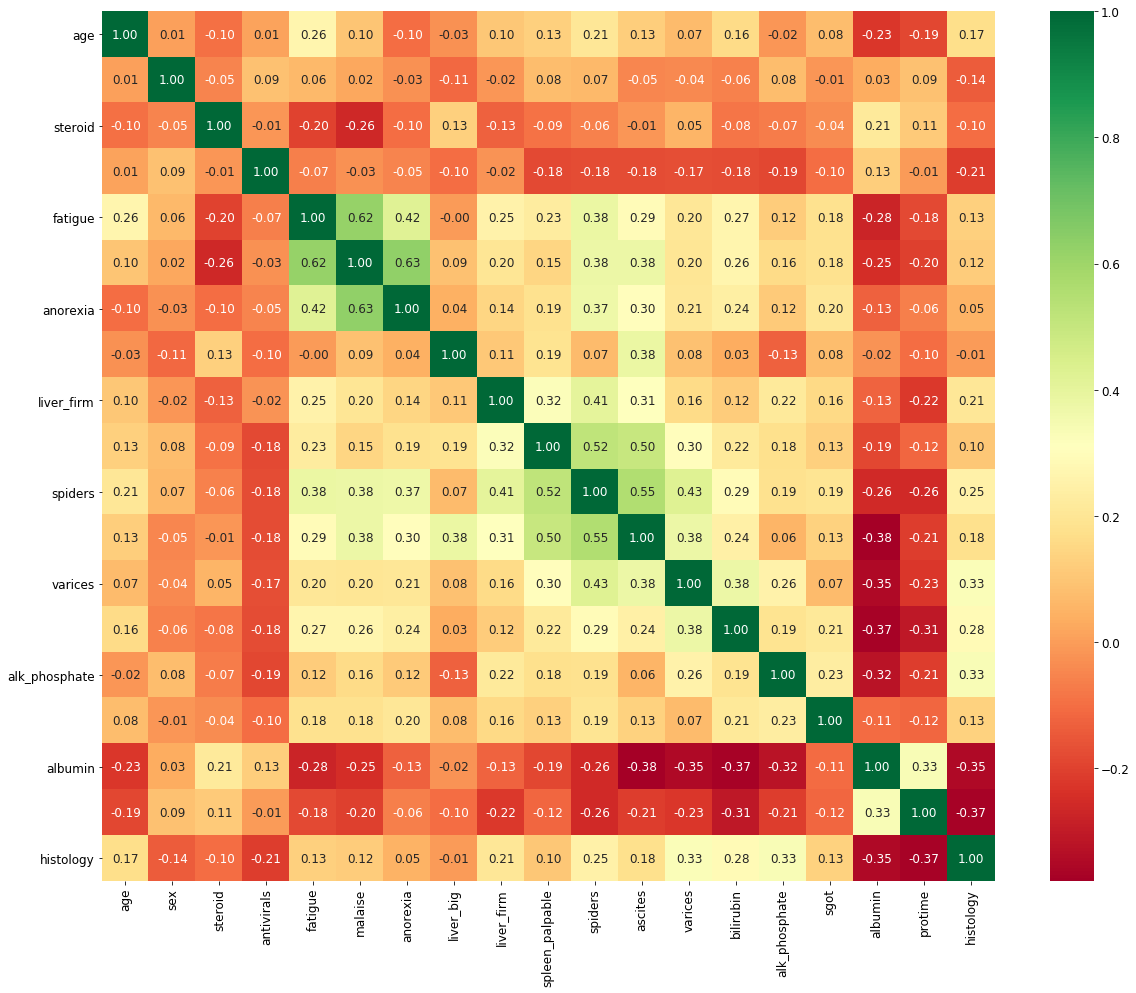

In [73]:
sns.heatmap(
    data=X.corr(),
    annot=True,
    fmt='.2f',
    cmap='RdYlGn'
)

fig = plt.gcf()
fig.set_size_inches(20, 16)

plt.show()

In [87]:
pipe = Pipeline(steps=[
    ('preprocess', StandardScaler()),
    ('feature_selection', PCA()),
    ('classification', LogisticRegression())
])

In [88]:
c_values = [0.1, 1, 10, 100, 1000]
n_values = range(2, 31)
random_state = 42

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.20
)

std_scaler = StandardScaler()

X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

pca = PCA(
    n_components=best_params.get('feature_selection__n_components'),
    random_state=best_params.get('feature_selection__random_state')
)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)
print('\nPCA sum: {:.2f}%'.format(sum(pca.explained_variance_ratio_) * 100))

log_reg = LogisticRegression(
    C=best_params.get('classification__C'),
    penalty=best_params.get('classification__penalty'),
    solver=best_params.get('classification__solver'),
    multi_class=best_params.get('classification__multi_class'),
    random_state=best_params.get('classification__random_state'),
)

log_reg.fit(X_train_pca, y_train)

log_reg_predict = log_reg.predict(X_test_pca)
log_reg_predict_proba = log_reg.predict_proba(X_test_pca)[:, 1]

print('LogisticRegression Accuracy: {:.2f}%'.format(accuracy_score(y_test, log_reg_predict) * 100))
print('LogisticRegression AUC: {:.2f}%'.format(roc_auc_score(y_test, log_reg_predict_proba) * 100))
print('LogisticRegression Classification report:\n\n', classification_report(y_test, log_reg_predict))
print('LogisticRegression Training set score: {:.2f}%'.format(log_reg.score(X_train_pca, y_train) * 100))
print('LogisticRegression Testing set score: {:.2f}%'.format(log_reg.score(X_test_pca, y_test) * 100))

[0.23136395 0.09440809 0.08769928 0.07163434 0.06290606 0.05627439
 0.05342053 0.04882016]

PCA sum: 70.65%
LogisticRegression Accuracy: 90.32%
LogisticRegression AUC: 83.33%
LogisticRegression Classification report:

               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.92      0.96      0.94        24

    accuracy                           0.90        31
   macro avg       0.88      0.84      0.85        31
weighted avg       0.90      0.90      0.90        31

LogisticRegression Training set score: 89.52%
LogisticRegression Testing set score: 90.32%


In [90]:
log_reg_param_grid = [
    {
        'feature_selection__random_state': [random_state],
        'feature_selection__n_components': n_values,
        'classification__C': c_values,
        'classification__penalty': ['l1'],
        'classification__solver': ['liblinear'],
        'classification__multi_class': ['ovr'],
        'classification__random_state': [random_state]
    },
    {
        'feature_selection__random_state': [random_state],
        'feature_selection__n_components': n_values,
        'classification__C': c_values,
        'classification__penalty': ['l2'],
        'classification__solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'classification__multi_class': ['ovr'],
        'classification__random_state': [random_state]
    }
]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.20
)

std_scaler = StandardScaler()

X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

pca = PCA(
    n_components=best_params.get('feature_selection__n_components'),
    random_state=best_params.get('feature_selection__random_state')
)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(pca.explained_variance_ratio_)
print('\nPCA sum: {:.2f}%'.format(sum(pca.explained_variance_ratio_) * 100))

log_reg = LogisticRegression(
    C=best_params.get('classification__C'),
    penalty=best_params.get('classification__penalty'),
    solver=best_params.get('classification__solver'),
    multi_class=best_params.get('classification__multi_class'),
    random_state=best_params.get('classification__random_state'),
)

log_reg.fit(X_train_pca, y_train)

log_reg_predict = log_reg.predict(X_test_pca)
log_reg_predict_proba = log_reg.predict_proba(X_test_pca)[:, 1]

print('LogisticRegression Accuracy: {:.2f}%'.format(accuracy_score(y_test, log_reg_predict) * 100))
print('LogisticRegression AUC: {:.2f}%'.format(roc_auc_score(y_test, log_reg_predict_proba) * 100))
print('LogisticRegression Classification report:\n\n', classification_report(y_test, log_reg_predict))
print('LogisticRegression Training set score: {:.2f}%'.format(log_reg.score(X_train_pca, y_train) * 100))
print('LogisticRegression Testing set score: {:.2f}%'.format(log_reg.score(X_test_pca, y_test) * 100))

[0.23136395 0.09440809 0.08769928 0.07163434 0.06290606 0.05627439
 0.05342053 0.04882016]

PCA sum: 70.65%
LogisticRegression Accuracy: 90.32%
LogisticRegression AUC: 83.33%
LogisticRegression Classification report:

               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.92      0.96      0.94        24

    accuracy                           0.90        31
   macro avg       0.88      0.84      0.85        31
weighted avg       0.90      0.90      0.90        31

LogisticRegression Training set score: 89.52%
LogisticRegression Testing set score: 90.32%


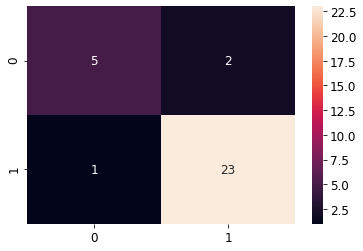

In [92]:
outcome_labels = sorted(hepatitis.classification.unique())

# Confusion Matrix for LogisticRegression
sns.heatmap(
    confusion_matrix(y_test, log_reg_predict),
    annot=True,
    xticklabels=outcome_labels,
    yticklabels=outcome_labels
)

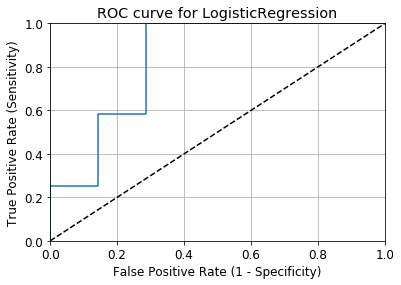

In [93]:
fpr, tpr, thresholds = roc_curve(y_test, log_reg_predict_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for LogisticRegression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [94]:
strat_k_fold = StratifiedKFold(
    n_splits=10,
    random_state=42
)

std_scaler = StandardScaler()

X_std = std_scaler.fit_transform(X)
X_pca = pca.fit_transform(X_std)

fe_score = cross_val_score(
    log_reg,
    X_pca,
    y,
    cv=strat_k_fold,
    scoring='f1'
)

print("LogisticRegression: F1 after 10-fold cross-validation: {:.2f}% (+/- {:.2f}%)".format(
    fe_score.mean() * 100,
    fe_score.std() * 2
))


LogisticRegression: F1 after 10-fold cross-validation: 90.69% (+/- 0.05%)
